# Import packages


In [1]:
import argparse
import numpy as np
import os
import sys
# import glog
import time
import cv2
sys.path.insert(0, "/media/allen/mass/pytorch_Realtime_Multi-Person_Pose_Estimation/")

# If CPU is used, cpu extension might be needed

In [2]:
#--cpu_extension /home/allen/R5/intel/computer_vision_sdk_2018.5.445/deployment_tools/inference_engine/lib/ubuntu_16.04/intel64/libcpu_extension_sse4.so 

# Add library path

In [3]:
sys.path.insert(0, "/home/acer/intel/computer_vision_sdk_2018.5.455/python/python3.6/ubuntu16")
from openvino.inference_engine import IENetwork, IEPlugin

# Loading model
set the path to model xml file

In [4]:
model_xml = "/home/allen/R5/intel/computer_vision_sdk_2018.5.445/deployment_tools/intel_models/human-pose-estimation-0001/FP32/human-pose-estimation-0001.xml"
model_bin = os.path.splitext(model_xml)[0] + ".bin"
plugin = IEPlugin(device="CPU", plugin_dirs=None)

# Read IR
print("Loading network files:\n\t{}\n\t{}".format(model_xml, model_bin))
net = IENetwork(model=model_xml, weights=model_bin)

Loading network files:
	/home/allen/R5/intel/computer_vision_sdk_2018.5.445/deployment_tools/intel_models/human-pose-estimation-0001/FP32/human-pose-estimation-0001.xml
	/home/allen/R5/intel/computer_vision_sdk_2018.5.445/deployment_tools/intel_models/human-pose-estimation-0001/FP32/human-pose-estimation-0001.bin


# Get model input/output name
Modification is needed if necessary

In [5]:
in_blob = next(iter(net.inputs))
print(in_blob)
out_blob = next(iter(net.outputs))
print(out_blob)

data
Mconv7_stage2_L1


# Get input shape by input name
Modification is needed if necessary

In [6]:
n, c, h, w = net.inputs[in_blob].shape
print("{} {} {} {}".format(n,c,h,w))

1 3 256 456


# human pose

In [19]:
path = "/media/allen/mass/recording0/2.jpg"
img = cv2.imread(path)
inputs = cv2.resize(img, (w,h)).transpose(2,0,1)[np.newaxis,:]
# inputs = (inputs - 127.5)/127.5
exec_net = plugin.load(network=net)
output = exec_net.infer(inputs={in_blob: inputs})
out_blob = list(output.keys())
print(out_blob)

['Mconv7_stage2_L1', 'Mconv7_stage2_L2']


In [20]:
output1, output2 = output[out_blob[0]], output[out_blob[1]]

In [21]:
heatmap = output2.transpose(0, 2, 3, 1)[0]
print(heatmap.shape)
real_shape = img.shape
print(real_shape)
heatmap = cv2.resize(heatmap, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
print(heatmap.shape)
heatmap = heatmap[0:real_shape[0], 0:real_shape[1], :]
print(heatmap.shape)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
print(heatmap.shape)

(32, 57, 19)
(257, 107, 3)
(256, 456, 19)
(256, 107, 19)
(257, 107, 19)


In [22]:
for i in range(19):
    print(heatmap[:,:,i].max())

0.00052536075
0.0003307653
0.00094211183
0.0017849056
0.00095764303
0.0010967632
0.002051281
0.00087322923
0.0030105854
0.0007234072
0.0007803161
0.0028925948
0.00049527624
0.010069357
0.00044806965
0.0005878433
0.00053855515
0.00075688964
0.99984396


In [23]:
paf = output1.transpose(0, 2, 3, 1)[0]
print(paf.shape)
paf = cv2.resize(paf, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
print(paf.shape)
paf = paf[0:real_shape[0], 0:real_shape[1], :]
print(paf.shape)
paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
print(paf.shape)

(32, 57, 38)
(256, 456, 38)
(256, 107, 38)
(257, 107, 38)


In [24]:
from network.post import decode_pose, plot_pose
from PIL import Image

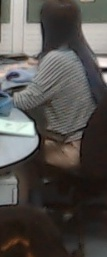

In [25]:
param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
# param = {'thre1': 0.001, 'thre2': 0.01, 'thre3': 0.1}
candidate, subset = decode_pose(
    img, param, heatmap, paf)  

to_plot, canvas = plot_pose(img, candidate, subset)
pil_img = Image.fromarray(canvas)
pil_img

# Set dummy input for inference

In [17]:
data = np.ones([1, 3, 112, 112])
data2 = np.zeros([1, 16, 56, 56])
data3 = np.zeros([1, 16, 28, 28])
data4 = np.zeros([1, 16, 14, 14])

exec_net = plugin.load(network=net)
del net

# Predict 
giving the dictionary of input to get the output by output blob name

In [16]:
output = exec_net.infer(inputs={'data1': data, 'data2': data2, 'data3': data3, 'data4': data4})[out_blob]
glog.info(output.shape)

I0729 13:09:32.353111 10498 <ipython-input-16-ac6122dd4cb8>:2] (1, 512)


# Command line version

In [3]:
import argparse
import numpy as np
import os
import sys
import glog
import time

sys.path.insert(0, "/home/acer/intel/computer_vision_sdk_2018.5.455/python/python2.7/ubuntu16")
from openvino.inference_engine import IENetwork, IEPlugin
def parse_arguments(argv):
    parser = argparse.ArgumentParser()
    parser.add_argument("-m", "--model", help="Path to an .xml file with a trained model.", required=True, type=str)
    parser.add_argument("-b", "--batch_size", help="Path to a folder with images or path to an image files", 
                        type=int)
    parser.add_argument("-l", "--cpu_extension",
                        help="MKLDNN (CPU)-targeted custom layers.Absolute path to a shared library with the kernels "
                             "impl.", type=str, default=None)
    parser.add_argument("-pp", "--plugin_dir", help="Path to a plugin folder", type=str, default=None)
    parser.add_argument("-d", "--device",
                        help="Specify the target device to infer on; CPU, GPU, FPGA or MYRIAD is acceptable. Sample "
                             "will look for a suitable plugin for device specified (CPU by default)", default="CPU",
                        type=str)
    parser.add_argument("--labels", help="Labels mapping file", default=None, type=str)
    parser.add_argument("-nt", "--number_top", help="Number of top results", default=10, type=int)
    parser.add_argument("-ni", "--number_iter", help="Number of inference iterations", default=1, type=int)
    parser.add_argument("-pc", "--perf_counts", help="Report performance counters", default=False, action="store_true")

    return parser.parse_args(argv)

args = parse_arguments(sys.argv[1:])
model_xml = args.model
model_bin = os.path.splitext(model_xml)[0] + ".bin"
plugin = IEPlugin(device=args.device, plugin_dirs=args.plugin_dir)

# Read IR
glog.info("Loading network files:\n\t{}\n\t{}".format(model_xml, model_bin))
net = IENetwork(model=model_xml, weights=model_bin)

out_blob = next(iter(net.outputs))
net.batch_size = args.batch_size

n, c, h, w = net.inputs['data'].shape

data = np.ones([1, 3, 112, 112])
data2 = np.zeros([1, 16, 56, 56])
data3 = np.zeros([1, 16, 28, 28])
data4 = np.zeros([1, 16, 14, 14])

exec_net = plugin.load(network=net)

output = exec_net.infer(inputs={'data': data, 'data2': data2, 'data3': data3, 'data4': data4})[out_blob]

glog.info(output.shape)

del net

usage: ipykernel_launcher.py [-h] -m MODEL [-b BATCH_SIZE] [-l CPU_EXTENSION]
                             [-pp PLUGIN_DIR] [-d DEVICE] [--labels LABELS]
                             [-nt NUMBER_TOP] [-ni NUMBER_ITER] [-pc]
ipykernel_launcher.py: error: the following arguments are required: -m/--model


SystemExit: 2

W0724 15:20:45.290234 14504 warnings.py:99] /home/allen/.pyenv/versions/3.6.8/envs/py368/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)

